## Variational Autoencoders for Anomaly Detection

In [115]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, LabelEncoder


import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

### Data preprocessing

Load data:

In [116]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

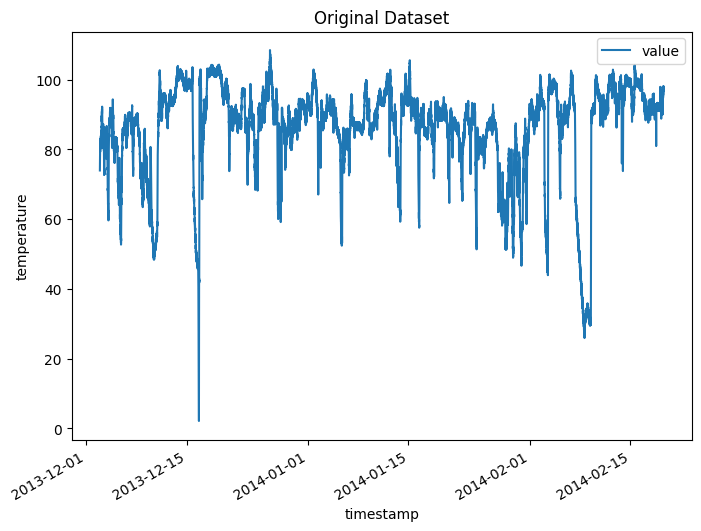

In [117]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(8, 6))
plt.ylabel("temperature")
plt.title("Original Dataset")

Anomalies labeled according to the NAB github (https://github.com/numenta/NAB/blob/master/labels/):

In [118]:
data['anomaly'] = 0 # 1 = anomaly, 0 = normal
instances_of_anomaly = [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
                        ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
                        ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
                        ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]

In [119]:
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'anomaly'] = 1

Make a temporary copy of the data with the timestamps for later plotting:

In [120]:
data_w_ts = data.copy()

The timestamps cover the Christmas and New Year holidays. Since we are dealing with an industrial machine, it stands to reason that its workload might be affected by holidays, and maybe even by the proximity (in time) of a holiday. Since variations in workload are expected, these are *not* considered anomalies.

In [121]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day

In [122]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

Distance from (closest) holiday:

In [123]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [124]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [125]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)

Converting timestamp into something plottable:

In [126]:
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,anomaly,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,0,2,12,21.250000,0,0,-23,13860189
1,74.935882,0,2,12,21.333333,0,0,-23,13860192
2,76.124162,0,2,12,21.416667,0,0,-23,13860195
3,78.140707,0,2,12,21.500000,0,0,-23,13860198
4,79.329836,0,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,0,19,2,15.083333,2,0,49,13928223
22691,97.804168,0,19,2,15.166667,2,0,49,13928226
22692,97.135468,0,19,2,15.250000,2,0,49,13928229
22693,98.056852,0,19,2,15.333333,2,0,49,13928232


Continuous and categorical variables:

In [127]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

Encoding categorical:

In [128]:
label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,value,anomaly,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,0,1,2,21.250000,0,0,-23,13860189
1,74.935882,0,1,2,21.333333,0,0,-23,13860192
2,76.124162,0,1,2,21.416667,0,0,-23,13860195
3,78.140707,0,1,2,21.500000,0,0,-23,13860198
4,79.329836,0,1,2,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,0,18,1,15.083333,2,0,49,13928223
22691,97.804168,0,18,1,15.166667,2,0,49,13928226
22692,97.135468,0,18,1,15.250000,2,0,49,13928229
22693,98.056852,0,18,1,15.333333,2,0,49,13928232


Do one-hot encoding:

In [129]:
data = pd.get_dummies(data.iloc[:,:], columns=cat_vars)
data

,value,anomaly,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,73.967322,0,21.250000,-23,13860189,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,74.935882,0,21.333333,-23,13860192,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,76.124162,0,21.416667,-23,13860195,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,78.140707,0,21.500000,-23,13860198,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,79.329836,0,21.583333,-23,13860201,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,98.185415,0,15.083333,49,13928223,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,97.804168,0,15.166667,49,13928226,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,97.135468,0,15.250000,49,13928229,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,98.056852,0,15.333333,49,13928232,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


Splitting into training, validation and testing data:

In [130]:
test_ratio = 0.3
# tr_idx = np.random.choice(np.arange(data.shape[0]), size=round(data.shape[0] * (1 - test_ratio)), replace=False)
# tst_idx = list(set(range(data.shape[0])).difference(set(tr_idx)))
# len(tr_idx), len(tst_idx)

In [131]:
# tr_data = data.iloc[tr_idx]
# tst_data = data.iloc[tst_idx]
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

Normalize continuous variables:

In [132]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

Drop anomaly column for training and testing, but keep the testing one for later use:

In [134]:
train = tr_data_scaled[tr_data_scaled.anomaly == 0]
train = train.drop(columns=['anomaly'])
train

,value,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,day_5,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-1.224398,1.336685,-1.866199,-1.732808,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,-1.134136,1.348691,-1.866199,-1.732590,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,-1.023399,1.360698,-1.866199,-1.732372,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,-0.835474,1.372704,-1.866199,-1.732153,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,-0.724658,1.384711,-1.866199,-1.731935,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.127174,1.684873,1.825637,1.731208,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.120220,1.696879,1.825637,1.731426,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.140016,1.708885,1.825637,1.731644,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.060621,1.720892,1.825637,1.731863,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [135]:
labels_of_test = tst_data_scaled['anomaly'].tolist()
test = tst_data_scaled.drop(columns=['anomaly'])

Converting to array for inputing to the model:

In [136]:
train = train.to_numpy()
train = np.asarray(train).astype(np.float32)
test = test.to_numpy()
test = np.asarray(test).astype(np.float32)

(Btw, we assume the signal statistics are not varying)

### VAE Model [OLD]

There was an attempt at modularizing the code but for now it is not complete so we're just putting everything here :)

In [137]:
# from model.vae_model import VAEModel

# input_dim = train.shape[1]
# vae = VAEModel(input_dim, intermediate_dim=int(input_dim/2), latent_dim=int(input_dim/3))

In [138]:
from utils.sample import sample
from model.VAELossLayer import VAELossLayer

Hyperparameters:

In [139]:
train.shape[1]

47

In [140]:
input_dim = train.shape[1]
input_shape = (input_dim,)
# intermediate_dim = int(input_dim / 2)
intermediate_dim = int(input_dim / 2)
# latent_dim = int(input_dim / 3)
latent_dim = int(input_dim / 4)
beta = 0.05
# lr = 0.0001
lr = 0.01
opt = optimizers.Adam(learning_rate=lr)

Full VAE Model:

In [141]:
inputs = Input(shape=input_shape, name='encoder_input')

# Encoder model
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Reparameterization trick
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var, beta])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [142]:
vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 47)]                 0         []                            
                                                                                                  
 encoder (Functional)        (None, 11)                   1632      ['encoder_input[0][0]']       
                                                                                                  
 dense_12 (Dense)            (None, 23)                   1104      ['encoder_input[0][0]']       
                                                                                                  
 decoder (Functional)        (None, 47)                   1404      ['encoder[0][0]']             
                                                                                            

Training:

In [143]:
history = vae_model.fit(x=train,y=train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=256,
                        validation_split=0.25,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)])

Epoch 1/1000
44/44 [==============================] - 1s 9ms/step - loss: 1715.4668 - decoder_loss: 0.1251 - vae_loss_layer_4_loss: 0.0728 - val_loss: 1785.9509 - val_decoder_loss: 0.0444 - val_vae_loss_layer_4_loss: 0.1419
Epoch 2/1000
44/44 [==============================] - 0s 3ms/step - loss: 1267.0358 - decoder_loss: 0.0500 - vae_loss_layer_4_loss: 0.0728 - val_loss: 1784.4478 - val_decoder_loss: 0.0516 - val_vae_loss_layer_4_loss: 0.1419
Epoch 3/1000
44/44 [==============================] - 0s 3ms/step - loss: 1251.8325 - decoder_loss: 0.0524 - vae_loss_layer_4_loss: 0.0728 - val_loss: 1793.5017 - val_decoder_loss: 0.0586 - val_vae_loss_layer_4_loss: 0.1419
Epoch 4/1000
44/44 [==============================] - 0s 3ms/step - loss: 1223.8546 - decoder_loss: 0.0544 - vae_loss_layer_4_loss: 0.0728 - val_loss: 1793.5900 - val_decoder_loss: 0.0600 - val_vae_loss_layer_4_loss: 0.1419
Epoch 5/1000
44/44 [==============================] - 0s 3ms/step - loss: 1210.1869 - decoder_loss: 0.05

Plotting the model loss:

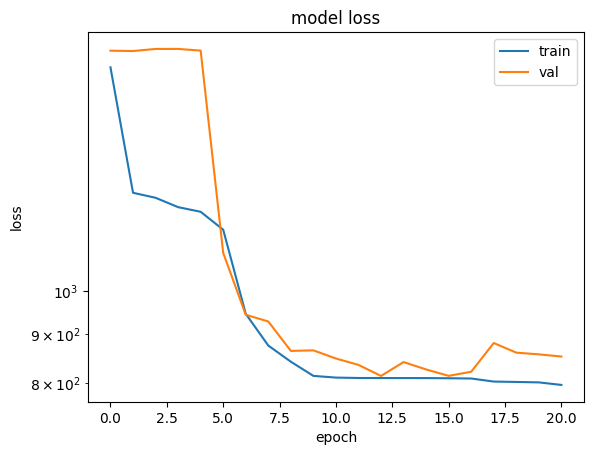

In [144]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');
plt.show()

In [145]:
history.history['loss'][-1], history.history['val_loss'][-1]

(796.55712890625, 853.1439208984375)

### Anonaly Detection

In [146]:
train_pred = vae_model.predict(train)[0]

461/461 [==============================] - 1s 1ms/step


In [147]:
from utils.get_error_term import get_error_term
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector):.5f}\nmedian error {np.median(mae_vector):.5f}\n99Q: {np.quantile(mae_vector, 0.99):.5f}')

Avg error 0.24051
median error 0.23460
99Q: 0.49405


We now plot the histogram of the normal values 

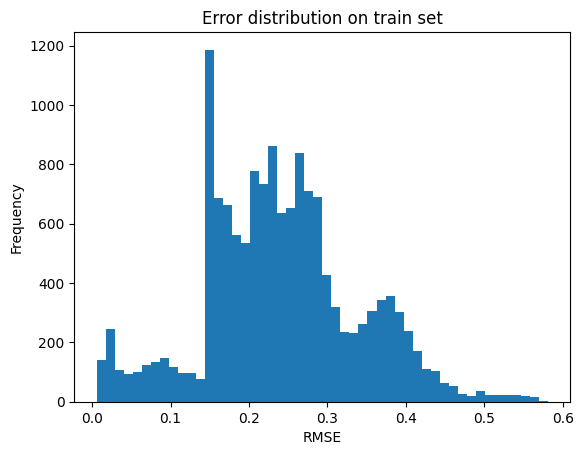

In [148]:
plt.hist(mae_vector, bins=50)
plt.title('Error distribution on train set')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()

Setting the anomaly threshold

In [149]:
error_thresh = np.max(mae_vector)           #np.quantile(mae_vector, 0.99)
print(f'Setting threshold on {error_thresh:.5f}')

Setting threshold on 0.58075


Actual percentage of anomalies in the test set:

In [150]:
#Actual ratio of anomalies 
ratio_anomalies_test = np.count_nonzero(labels_of_test) / len(labels_of_test)
print(f"Ratio of anomalies in the test set = {ratio_anomalies_test*100:.3f}%")

Ratio of anomalies in the test set = 16.654%


Percetage of anomalies detected:

In [151]:
test_pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(test_pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test):.5f}\nMedian error {np.median(mae_vector_test):.5f}')
anomalies = (mae_vector_test > error_thresh)

detected_ratio_anomalies = np.count_nonzero(anomalies) / len(anomalies)
print(f"Ratio of anomalies detected = {detected_ratio_anomalies*100:.3f}%")

213/213 [==============================] - 0s 1ms/step
Avg error 0.53458
Median error 0.52407
Ratio of anomalies detected = 30.592%


Histogram of test set - includes anomalies:

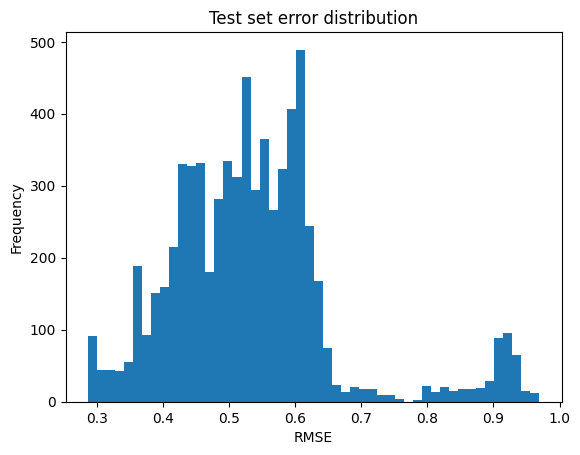

In [152]:
plt.hist(mae_vector_test, bins=50)
plt.title('Test set error distribution')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()

Locations of detected anomalies vs actual anomalies:

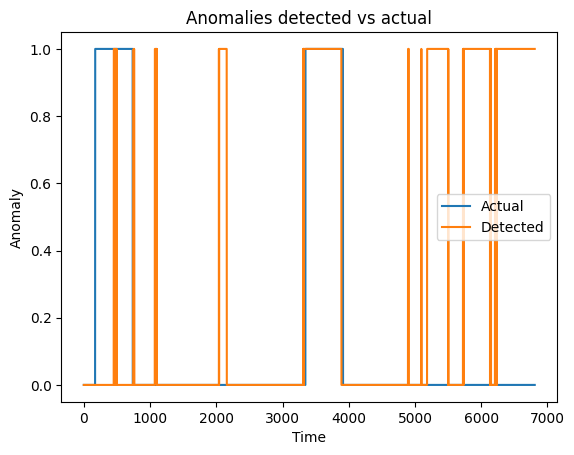

In [153]:
plt.plot(labels_of_test)
plt.plot(anomalies)
plt.title('Anomalies detected vs actual')
plt.xlabel('Time')
plt.ylabel('Anomaly')
plt.legend(['Actual', 'Detected'])
plt.show()

Classification Metrics:

In [154]:
from sklearn.metrics import classification_report
print(classification_report(labels_of_test, anomalies))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      5675
           1       0.27      0.50      0.35      1134

    accuracy                           0.69      6809
   macro avg       0.58      0.62      0.58      6809
weighted avg       0.78      0.69      0.73      6809



Visualize locations of anomalies:

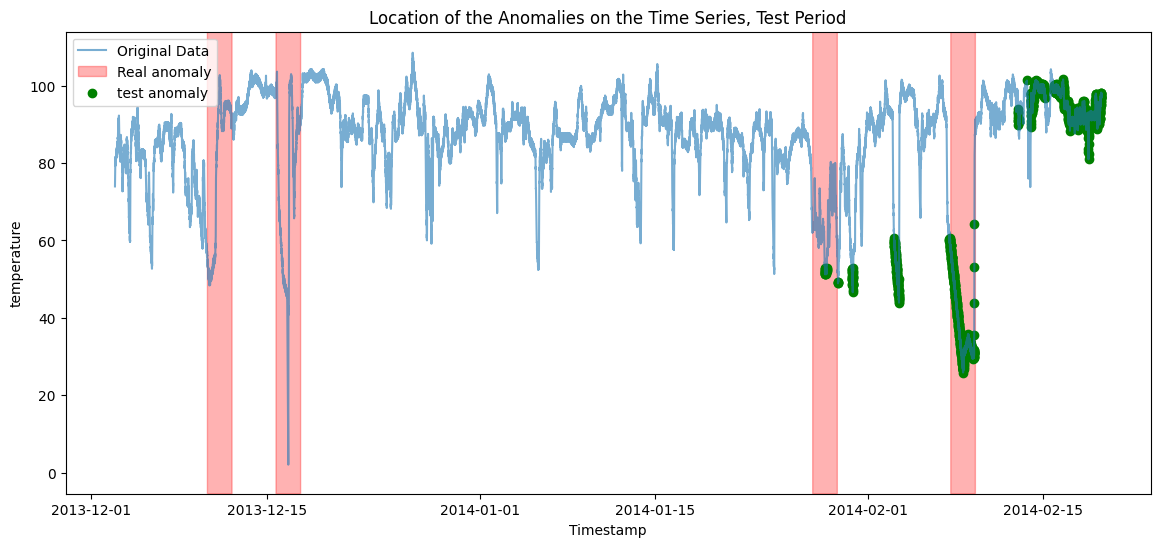

In [158]:
tst_data.loc[tst_data['detected_anomaly'], 'detected_anomaly'] = True
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :].copy()
tst_data['timestamp'] = ts
tst_data = tst_data[['timestamp', 'value', 'anomaly', 'detected_anomaly']].copy()

anomalies_ts = data_w_ts.loc[data_w_ts['anomaly'] == 1, ('timestamp', 'value')].copy()
testing = tst_data.loc[tst_data['detected_anomaly'] == True, ('timestamp', 'value')].copy()
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=data_w_ts['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")
plt.show()